# Learning from Examples: Line Fitting

We want to fit a straight line to data (i.e., perform linear regression).

We will compare:

* Grid search over the loss function
* The analytical solution
* Gradient descent
* Stochastic Gradient descent


## Simulate some data with noise

**Unknown function:** $y = f(x) = w_1x + w_0 + N(0,1)$ with $w_0 = 3$ and $w_1 = 7$

In [71]:
f <- function(x, w0, w1) w1 * x + w0 + rnorm(length(x), mean = 0, sd = 1)

Simulate 100 examples $(x, y)$ from $f$. We randomly choose the data in the $[0,1]$ interval for $x$.

In [ ]:
N <- 100
real_w0 <- 3
real_w1 <- 7

In [ ]:
x <- runif(N, 0, 1)
y <-  f(x, real_w0, real_w1)

In [72]:
xy <- data.frame(x, y)
head(xy)

,x,y
,<dbl>,<dbl>
1,0.8449622,10.480792
2,0.5915126,8.528362
3,0.5858116,8.385942
4,0.6135237,7.086012
5,0.7112553,9.762752
6,0.2162088,4.698817


Plot the simulated data and add the 

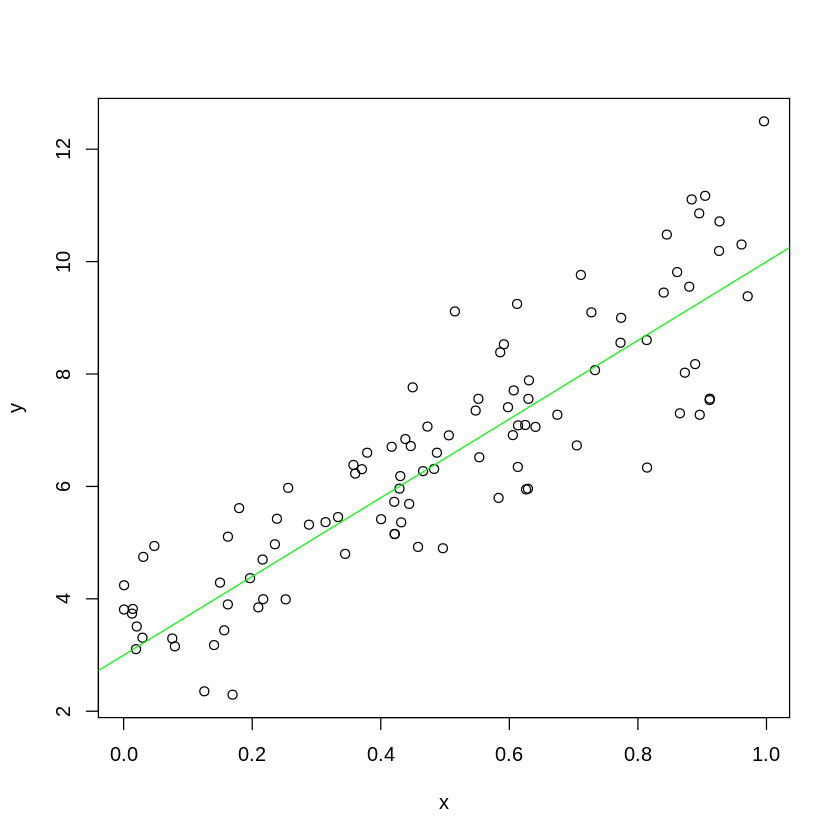

In [73]:
plot(xy)
abline(a = real_w0, b = real_w1, col = "green")

## Define the Hypothesis and the Loss Function

### Hypothesis space: Line equations 

$h_w(x) = \hat{y} = w_1 x + w_0$

In [74]:
y_hat <- function(x, w0, w1) w1 * x + w0

### Loss function: Squared-error loss

$L(h_w) = \sum_{j=1}^N (y_j - h_w(x_j))^2$

In [75]:
L2 <- function(y, y_hat) sum((y - y_hat)^2)

## Grid search

Create a grid of w0 and w1 values

In [76]:
resolution <- 25
grid <- data.frame(
  w0 = rep(seq(0, 10, length.out = resolution), times = resolution),
  w1 = rep(seq(0, 10, length.out = resolution), each = resolution)
)

In [77]:
grid$L2 <- with(xy, 
  apply(grid, MARGIN = 1, FUN = function(w) 
    L2(y, y_hat(x, w["w0"], w["w1"]))
  )
)

Find minimum grid cell

In [78]:
opt <- grid[which.min(grid$L2), ]
opt

,w0,w1,L2
,<dbl>,<dbl>,<dbl>
409,3.333333,6.666667,106.8295


Plot loss function surface

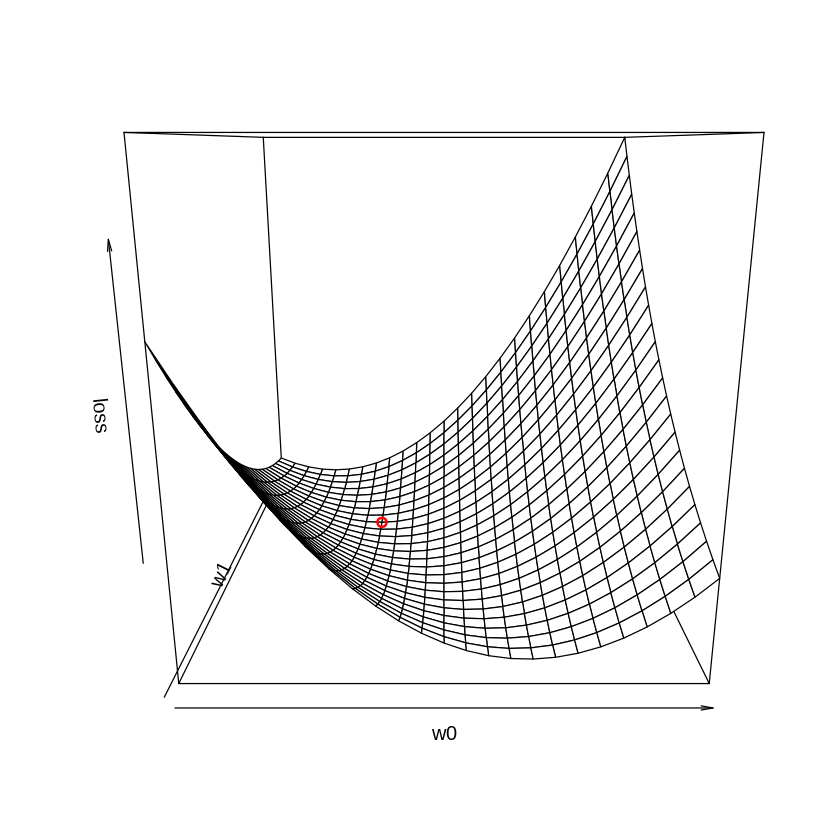

In [79]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss")
points(
  trans3d(
    x = opt[,"w0"]/max(grid[,"w0"]), 
    y = opt[,"w1"]/max(grid[,"w1"]), 
    z = opt[,"L2"], 
    pmat = pmat), 
  col = "red", lwd = 2)

plot regression line

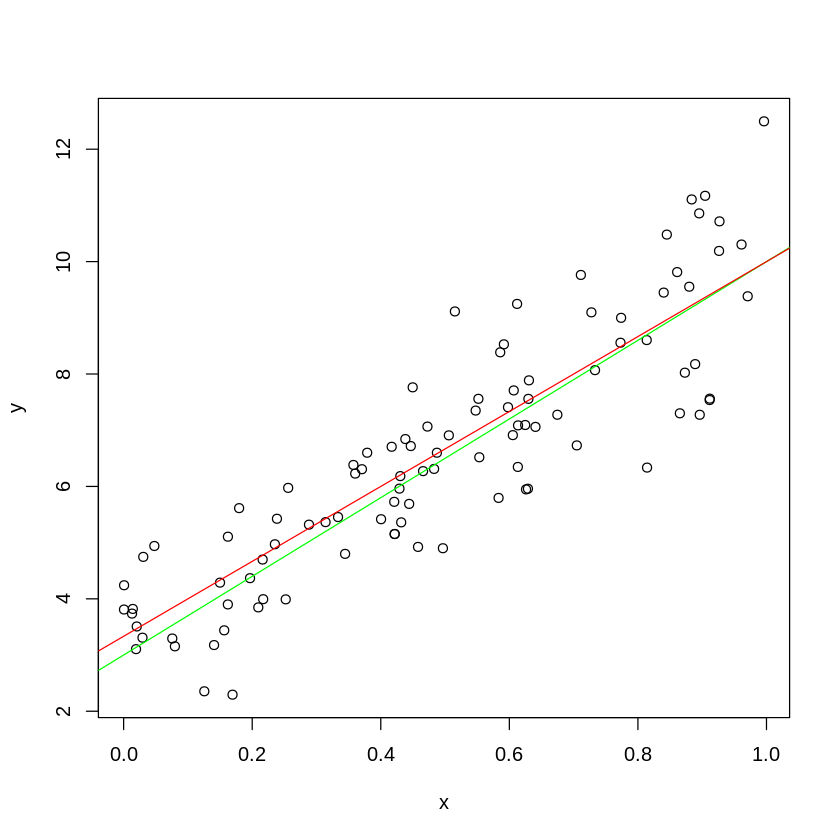

In [80]:
plot(xy)
abline(a = real_w0, b = real_w1, col = "green")
abline(a = opt[,"w0"], b = opt[,"w1"], col = "red")

## Analytic solution

Loss is minimized by setting the gradient of the loss funtion to 0 at:

$w_1 = \frac{N(\sum x_j y_j) - (\sum x_j)(\sum y_j)}{N(\sum x_j^2) - (\sum x_j)^2}$

$w_0 = \frac{\sum y_j - w_1 (\sum x_j)}{N}$

In [81]:
w1 <- with(xy, (N * sum(x*y) - sum(x)*sum(y)) / (N * sum(x^2) - sum(x)^2))
w1

[1] 6.852387

In [82]:
w0 <- with(xy, (sum(y) - w1 * sum(x)) / N)
w0

[1] 3.198017

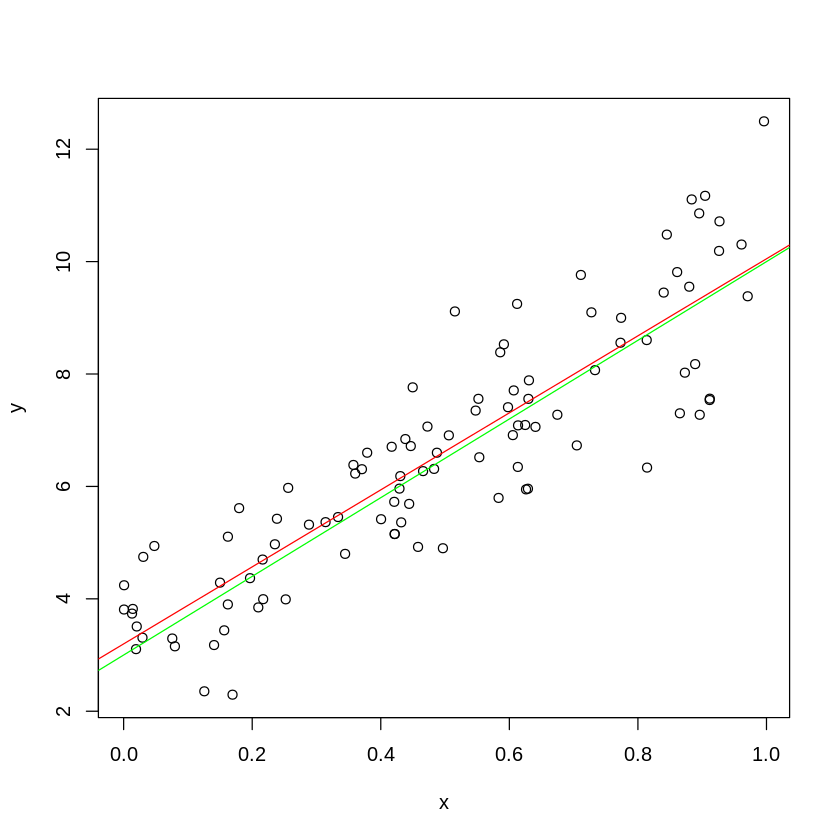

In [83]:
plot(xy)
abline(a = real_w0, b = real_w1, col = "green")
abline(a = w0, b = w1, col = "red")

## Gradient descent

### Batch gradient descent

In [84]:
line_BGD <- function(xy, alpha = 0.001, eps = 1e-6) {
  
  #' start with some points from the parameter space
  w0 <- 0
  w1 <- 0
  
  # we use loss improvement > eps to check for convergence
  step <- 0
  improvement <- Inf
  loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
  history <- data.frame(w0, w1, loss)
  #' update weights
  while (improvement > eps) {
    old_loss <- loss
    step <- step + 1
    
    w0 <- with(xy, w0 + alpha * sum(y - y_hat(x, w0, w1)))
    w1 <- with(xy, w1 + alpha * sum((y - y_hat(x, w0, w1)) * x))
    
    loss <- L2(xy$y, y_hat(xy$x, w0, w1))
    improvement <- old_loss - loss
  
    history <- rbind(history, data.frame(w0, w1, loss))
  }
  list(w = c(w0 = w0, w1 = w1), history = history)
}

In [85]:
w <- line_BGD(xy) 
w$w

w0       w1 
3.199624 6.849318

Learning curve

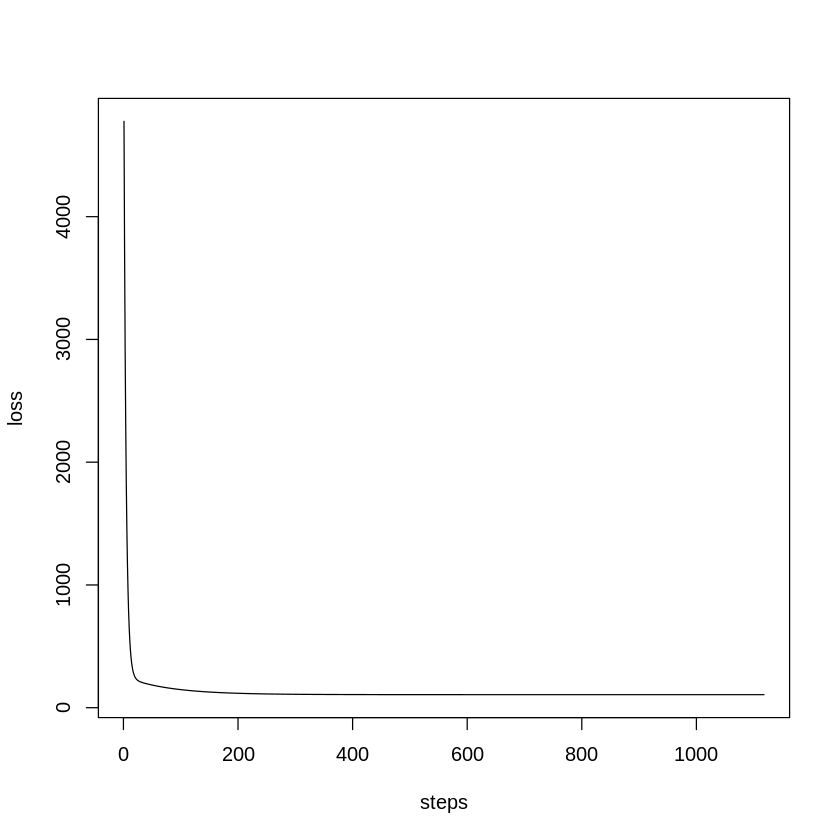

In [86]:
plot(w$history$loss, type = "l", xlab = "steps", ylab = "loss")

Learning path

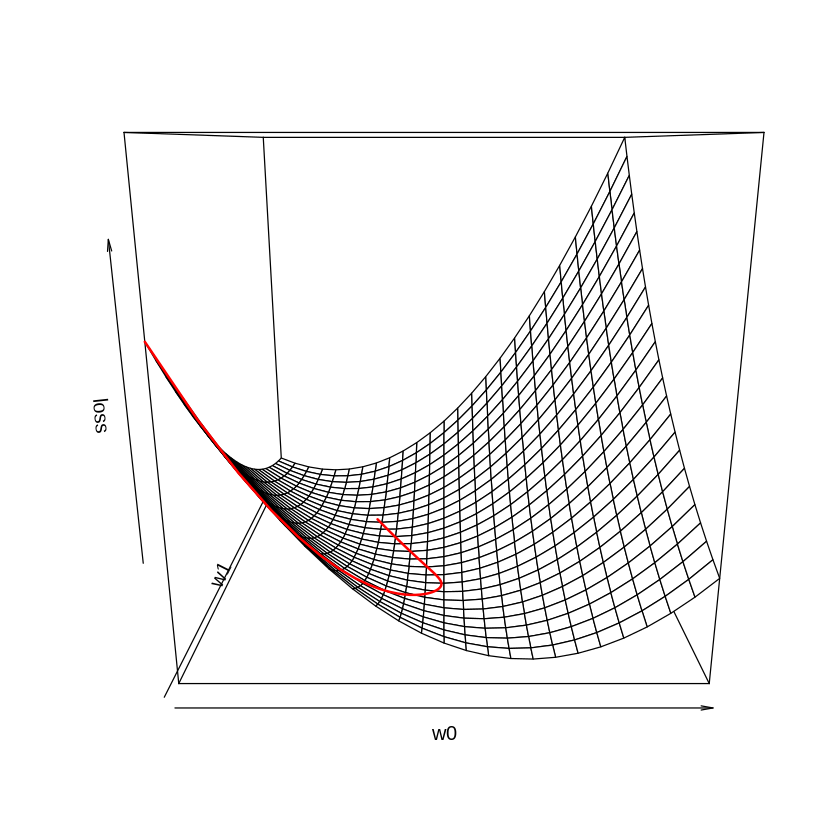

In [87]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss")
lines(
  trans3d(
    x = w$history[,"w0"]/max(grid[,"w0"]), 
    y = w$history[,"w1"]/max(grid[,"w1"]), 
    z = w$history[,"loss"], 
    pmat = pmat), 
  col = "red", lwd = 2)

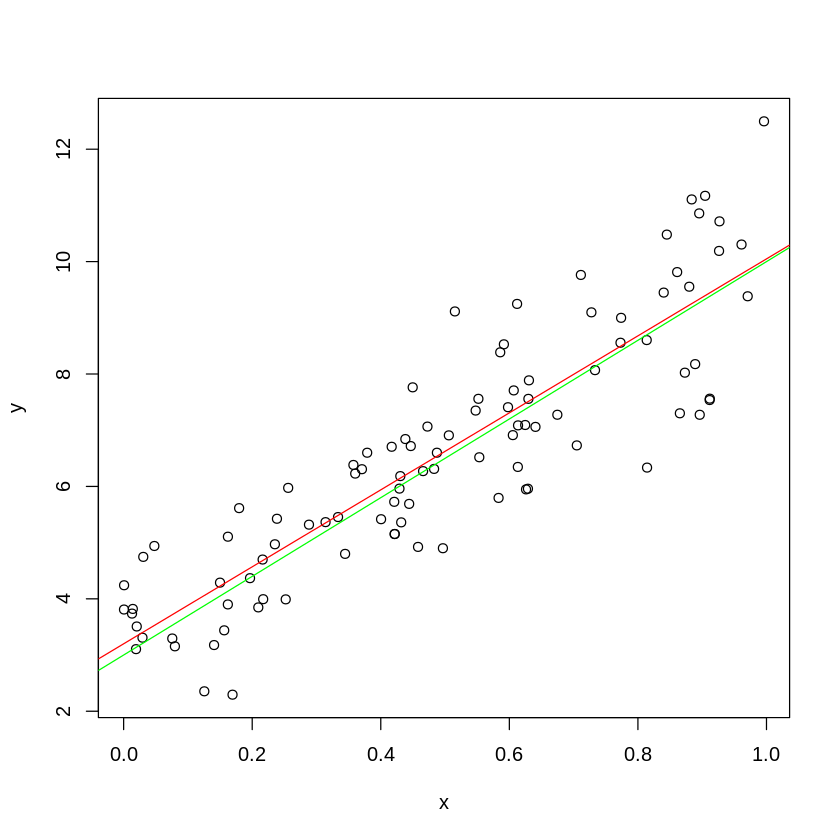

In [88]:
plot(xy)
abline(a = real_w0, b = real_w1, col = "green")
abline(a = w$w["w0"], b = w$w["w1"], col = "red")

### SGD with minibatch

 Convergence is a problem since loss on all the data can increase.
 I use for convergence a number of tries with a loss improvement less than eps. I also reduce alpha over time using $\alpha/t^\delta$ for better convergence. 

In [89]:
line_SGD <- function(xy, alpha = 0.001, delta = 1e-6, eps = 1e-6, 
  tries = 10, batch_size = 10) {
  
  #' start with some points from the parameter space
  w0 <- 0
  w1 <- 0
  
  # we use loss improvement > eps to check for convergence
  step <- 0
  improvements <- 0
  loss <- L2(xy$y, y_hat(xy$x, w0, w1))
  
  history <- data.frame(w0, w1, loss)
  
  #' update weights
  while (improvements < tries) {
    old_loss <- loss
    step <- step + 1
    
    mb <- xy[sample(nrow(xy), size = batch_size),]
    w0 <- with(mb, w0 + alpha/step^delta * sum(y - y_hat(x, w0, w1)))
    w1 <- with(mb, w1 + alpha/step^delta * sum((y - y_hat(x, w0, w1)) * x))
    
    loss <- L2(xy$y, y_hat(xy$x, w0, w1))
    improvement <- old_loss - loss
    if(improvement < eps) improvements <- improvements + 1
    else improvements <- 0
    
    history <- rbind(history, data.frame(w0, w1, loss))
  }
  list(w = c(w0 = w0, w1 = w1), history = history)
}

In [90]:
w <- line_SGD(xy) 
w$w

w0       w1 
3.319551 6.679718

Learning curve

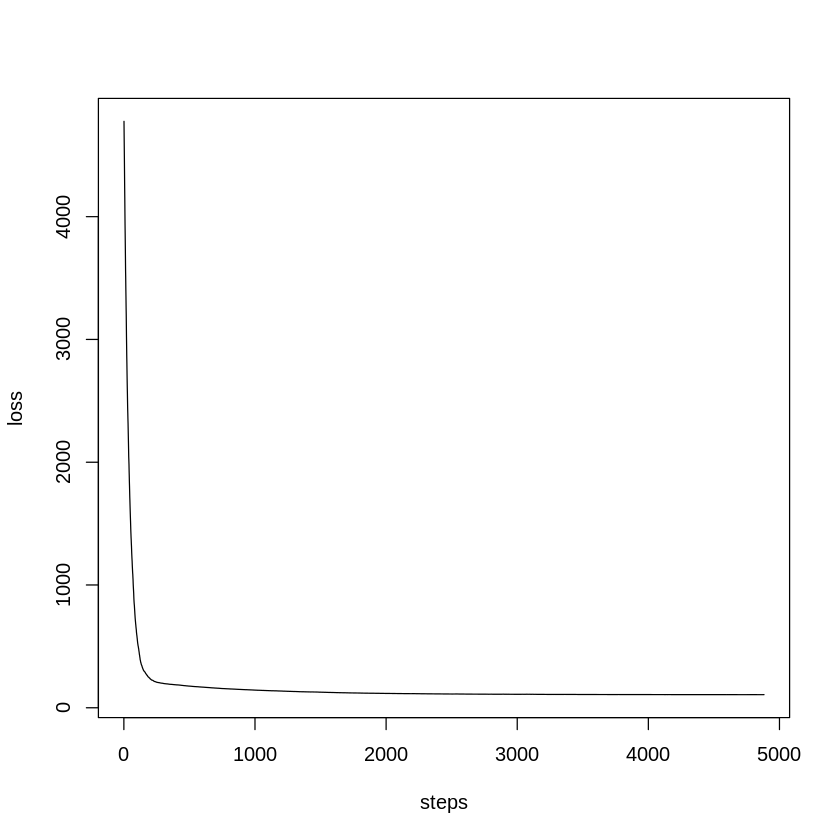

In [91]:
plot(w$history$loss, type = "l", xlab = "steps", ylab = "loss")

Learning path

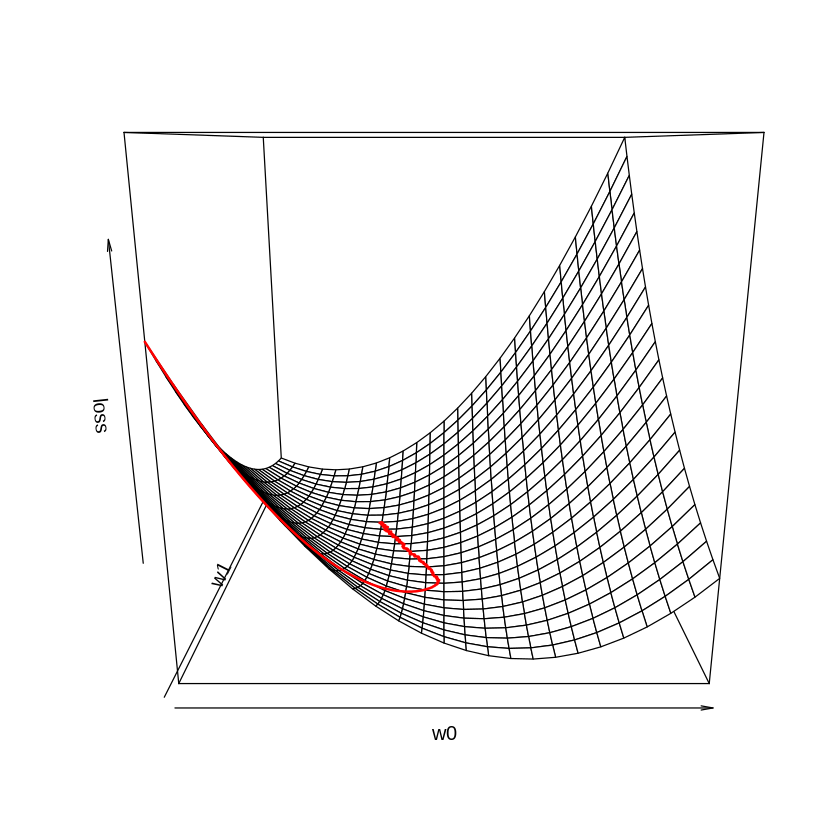

In [92]:
pmat <- persp(matrix(grid$L2, nrow = resolution), 
  xlab = "w0", ylab = "w1", zlab = "loss")
lines(
  trans3d(
    x = w$history[,"w0"]/max(grid[,"w0"]), 
    y = w$history[,"w1"]/max(grid[,"w1"]), 
    z = w$history[,"loss"], 
    pmat = pmat), 
  col = "red", lwd = 2)

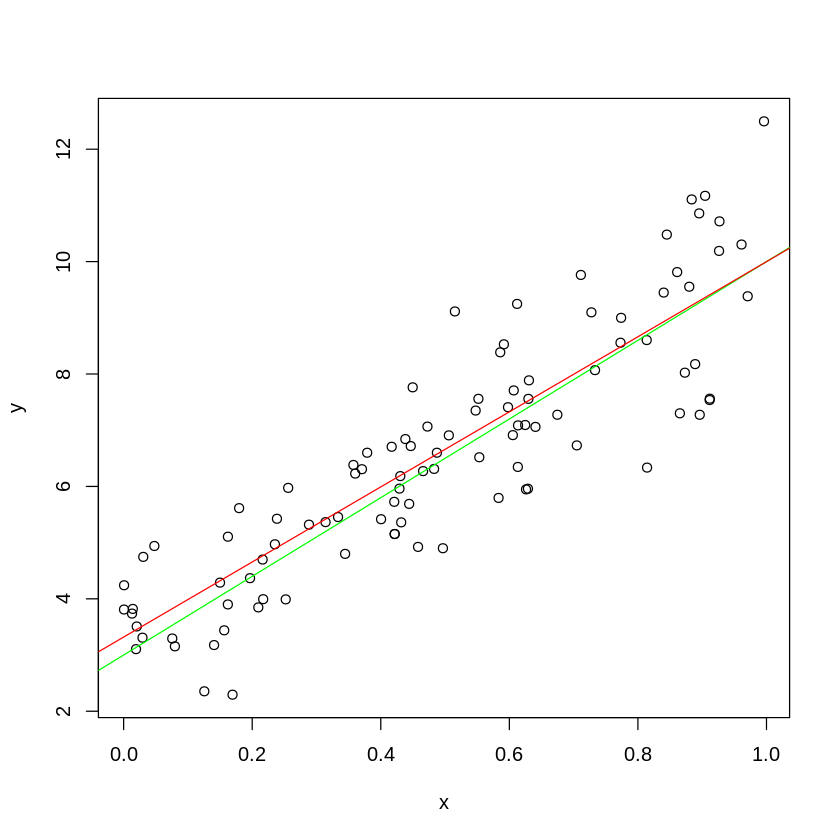

In [93]:
plot(xy)
abline(a = real_w0, b = real_w1, col = "green")
abline(a = w$w["w0"], b = w$w["w1"], col = "red")